# 6. Water resources data science

1. Accessing Data with APIs  
   1. APIs basics  
      1. Similarities and differences to snowflake   
      2. Ryan Hankins will post a common dataset  
   2. Accessing APIs with the python “requests” module
   4. Loading API URL paths directly into pandas dataframes   
2. Query OpenET API, get ET data
    3. demonstrate point query and polygon query
    4. get some ET data - both point and poly 
    5. Talk about how OpenET is built on Earth Engine
        6. benefits of earth engine
3. Take ET data over area into a 2d or 3d numpy array 
4. Create pandas dataframe from time series with the point data, with datetime index 
5. Interpolate in two dimensions two subsets of the gridded data
    6. Use Scipy 
       1. Morphology  
       2. Interpolate.griddata
    6. talk about uncertainty 
    7. Plot ET from several points on the same time series the same time series with pandas / seaborn
    8. Determine date of max ET for location
    9. Compare to date of max streamflow?

In this module, we will walk through an example data science project, starting from scratch. We will make use of the resources that we have gained familariarty with in the past modules. 

## Organizing a data science project

Like in life, organization in software and data science is critically important. Organizing a project well from the outset is likely to save time in the later stages, and as collaborators are added and/or ownership changes. 

We will try as hard as we can to avoid the most common pitfall described in the below XKCD comic:

![data_flows](./img/6-data-pipeline.png)

Here is an example of how one might organize a data science project:

```
project_name
│   README.md
│   api_key.txt    
│
└───code/
│   │   00_get_data.py
│   │   01_process_data.py
│   │   02_analyze_data.py
│   │   03_plot_results.py
│   │   ...        
│   │
│   └───submodule/
│       │   file111.txt
│       │   file112.txt
│       │   ...
│   
└───data/
│   │
│   └───Source1/
│       │   file1.csv
│       │   file2.txt
│       │   ...
│       │
│   └───Source2/
│       │   file1.csv
│       │   file2.txt
│       │   ...
│
└───GIS/
│   │
│   └───Source1/
│       │   file1.geojson
│       │   file2.kml
│       │   ...
│       │
│   └───Source2/
│       │   file1.shp
│       │   file2.xlsx
│       │   ...
│   
└───results
│   │
│   └───Analysis1/
│       │   file1.csv
│       │   file2.txt
│       │   ...
│       │
│   └───Analysis2/
│       │   file1.csv
│       │   file2.txt
│       │   ...
```

Lets spend a few minutes discussing the above - what are some alternate naming conventions you might adopt? What are some additional folders that might be added? 

## Water Resources Data Science Project - ET and GWL

Let's say we are interested in analyzing the dynamical interplay between groundwater levels and evapotranspiration. Let's develop a python workflow to do the following:

1. Read `.csv` data describing groundwater station locations (`stations.csv`)
2. Select a number of stations from the larger dataset based on a list of `station_ids`
3. Join the station data to groundwater level data based on a column value 
4. Use the location information contained in the `stations.csv` to determine the lat/lon of each station
5. For each groundwater monitoring location:
   * Determine lat/lon coordinates
   * Query the collocated ET data 
   * Organize ET and GWL time series data as dataframes
   * Ensure that time windows of data overlap
   * Write files to directory
6. Analyze the correlation and lag between peak ET and peak GWL
7. Plot and write our results to file

### Data Loading, Preparation, and EDA

Lets say we want to perform our analysis for the following site IDs:
```
['382913N1213131W001',
 '384082N1213845W001',
 '385567N1214751W001',
 '386016N1213761W001',
 '387511N1213389W001',
 '388974N1213665W001',
 '383264N1213191W001',
 '382548N1212908W001',
 '388943N1214335W001',
 '384121N1212102W001']
```

We can use `pandas` to read and inspect the data, filter for the appropriate `SITE_CODE` rows given by the IDs above, and finally join the `stations` and `measurements` data. 

In [1]:
import pandas as pd

# Read the GWL data csv files into pandas dataframes 
df_stns = pd.read_csv("./data/gwl/stations.csv")
df_gwl_all = pd.read_csv("./intro_proj/data/gwl/measurements_sep.csv")

In [2]:
# Inspect the columns of the data
df_gwl_all.head()

,STN_ID,SITE_CODE,WLM_ID,MSMT_DATE,WLM_RPE,WLM_GSE,RDNG_WS,RDNG_RP,WSE,RPE_WSE,GSE_WSE,WLM_QA_DESC,WLM_DESC,WLM_ACC_DESC,WLM_ORG_ID,WLM_ORG_NAME,MSMT_CMT,COOP_AGENCY_ORG_ID,COOP_ORG_NAME
0,4775,384931N1212618W001,1443624,2004-03-01T00:00:00Z,118.4,117.4,0.0,127.0,-8.6,127.0,126.0,NaN,Unknown,Water level accuracy is unknown,1,Department of Water Resources,NaN,1074,SACRAMENTO MUNICIPAL UTILITY DISTRICT
1,4775,384931N1212618W001,1443625,2003-10-01T00:00:00Z,118.4,117.4,0.0,121.7,-3.3,121.7,120.7,NaN,Unknown,Water level accuracy is unknown,1,Department of Water Resources,NaN,1074,SACRAMENTO MUNICIPAL UTILITY DISTRICT
2,4775,384931N1212618W001,1443622,2003-03-15T00:00:00Z,118.4,117.4,0.0,119.5,-1.1,119.5,118.5,NaN,Unknown,Water level accuracy is unknown,1,Department of Water Resources,NaN,1074,SACRAMENTO MUNICIPAL UTILITY DISTRICT
3,4775,384931N1212618W001,1443620,2002-10-01T00:00:00Z,118.4,117.4,0.0,128.9,-10.5,128.9,127.9,NaN,Unknown,Water level accuracy is unknown,1,Department of Water Resources,NaN,1074,SACRAMENTO MUNICIPAL UTILITY DISTRICT
4,4775,384931N1212618W001,1443621,2001-10-01T00:00:00Z,118.4,117.4,0.0,131.4,-13.0,131.4,130.4,NaN,Unknown,Water level accuracy is unknown,1,Department of Water Resources,NaN,1074,SACRAMENTO MUNICIPAL UTILITY DISTRICT


In [3]:
# Inspect the data types
df_gwl_all.dtypes

STN_ID                  int64
SITE_CODE              object
WLM_ID                  int64
MSMT_DATE              object
WLM_RPE               float64
WLM_GSE               float64
RDNG_WS               float64
RDNG_RP               float64
WSE                   float64
RPE_WSE               float64
GSE_WSE               float64
WLM_QA_DESC            object
WLM_DESC               object
WLM_ACC_DESC           object
WLM_ORG_ID              int64
WLM_ORG_NAME           object
MSMT_CMT               object
COOP_AGENCY_ORG_ID      int64
COOP_ORG_NAME          object
dtype: object

In [4]:
# Inspect the columns of the data
df_stns.head()

,STN_ID,SITE_CODE,SWN,WELL_NAME,LATITUDE,LONGITUDE,WLM_METHOD,WLM_ACC,BASIN_CODE,BASIN_NAME,COUNTY_NAME,WELL_DEPTH,WELL_USE,WELL_TYPE,WCR_NO,ZIP_CODE
0,51445,320000N1140000W001,NaN,Bay Ridge,35.5604,-121.755,USGS quad,Unknown,NaN,NaN,Monterey,NaN,Residential,Part of a nested/multi-completion well,NaN,92154
1,25067,325450N1171061W001,19S02W05K003S,NaN,32.5450,-117.106,Unknown,Unknown,9-033,Coastal Plain Of San Diego,San Diego,NaN,Unknown,Unknown,NaN,92154
2,25068,325450N1171061W002,19S02W05K004S,NaN,32.5450,-117.106,Unknown,Unknown,9-033,Coastal Plain Of San Diego,San Diego,NaN,Unknown,Unknown,NaN,92154
3,39833,325450N1171061W003,19S02W05K005S,NaN,32.5450,-117.106,Unknown,Unknown,9-033,Coastal Plain Of San Diego,San Diego,NaN,Unknown,Unknown,NaN,92154
4,25069,325450N1171061W004,19S02W05K006S,NaN,32.5450,-117.106,Unknown,Unknown,9-033,Coastal Plain Of San Diego,San Diego,NaN,Unknown,Unknown,NaN,92154


In [5]:
# Inspect the data types
df_stns.dtypes

STN_ID           int64
SITE_CODE       object
SWN             object
WELL_NAME       object
LATITUDE       float64
LONGITUDE      float64
WLM_METHOD      object
WLM_ACC         object
BASIN_CODE      object
BASIN_NAME      object
COUNTY_NAME     object
WELL_DEPTH     float64
WELL_USE        object
WELL_TYPE       object
WCR_NO          object
ZIP_CODE         int64
dtype: object

In [6]:
# Define our site ids:
site_ids = ['382913N1213131W001',
 '384082N1213845W001',
 '385567N1214751W001',
 '386016N1213761W001',
 '387511N1213389W001',
 '388974N1213665W001',
 '383264N1213191W001',
 '382548N1212908W001',
 '388943N1214335W001',
 '384121N1212102W001']

df_gwl = df_gwl_all[df_gwl_all['SITE_CODE'].isin(site_ids)]
df_gwl.head()

,STN_ID,SITE_CODE,WLM_ID,MSMT_DATE,WLM_RPE,WLM_GSE,RDNG_WS,RDNG_RP,WSE,RPE_WSE,GSE_WSE,WLM_QA_DESC,WLM_DESC,WLM_ACC_DESC,WLM_ORG_ID,WLM_ORG_NAME,MSMT_CMT,COOP_AGENCY_ORG_ID,COOP_ORG_NAME
1422,4824,382913N1213131W001,2662873,2020-09-17T00:00:00Z,44.8,43.5,4.0,95.0,-46.2,91.0,89.7,NaN,Steel tape measurement,Water level accuracy to nearest tenth of a foot,1,Department of Water Resources,Run 18,1,Department of Water Resources
1423,4824,382913N1213131W001,2662004,2020-08-28T00:00:00Z,44.8,43.5,4.9,9.5,40.2,4.6,3.3,NaN,Steel tape measurement,Water level accuracy to nearest tenth of a foot,1,Department of Water Resources,Run 18,1,Department of Water Resources
1424,4824,382913N1213131W001,2657077,2020-07-23T00:00:00Z,44.8,43.5,5.0,95.0,-45.2,90.0,88.7,NaN,Steel tape measurement,Water level accuracy to nearest tenth of a foot,1,Department of Water Resources,Run 18,1,Department of Water Resources
1425,4824,382913N1213131W001,2630628,2020-06-25T00:00:00Z,44.8,43.5,1.2,90.0,-44.0,88.8,87.5,NaN,Electric sounder measurement,Water level accuracy to nearest tenth of a foot,1,Department of Water Resources,Run 18,1,Department of Water Resources
1426,4824,382913N1213131W001,2624819,2020-05-22T00:00:00Z,44.8,43.5,3.3,90.0,-41.9,86.7,85.4,NaN,Steel tape measurement,Water level accuracy to nearest foot,1,Department of Water Resources,Run 18,1,Department of Water Resources


In [7]:
# It looks like there could be some duplicates in the GWL data 
# we can use the 'drop duplicates' function to eliminate them
df_gwl = df_gwl.drop_duplicates()

In [8]:
# Set the 'MSMT_DATE' column to a pandas datetime object 
# Note that the data type is object - we must first conver to string 
datetime_strings = df_gwl.loc[:,'MSMT_DATE'].astype(str)
df_gwl.loc[:,'Datetime'] = pd.to_datetime(datetime_strings)

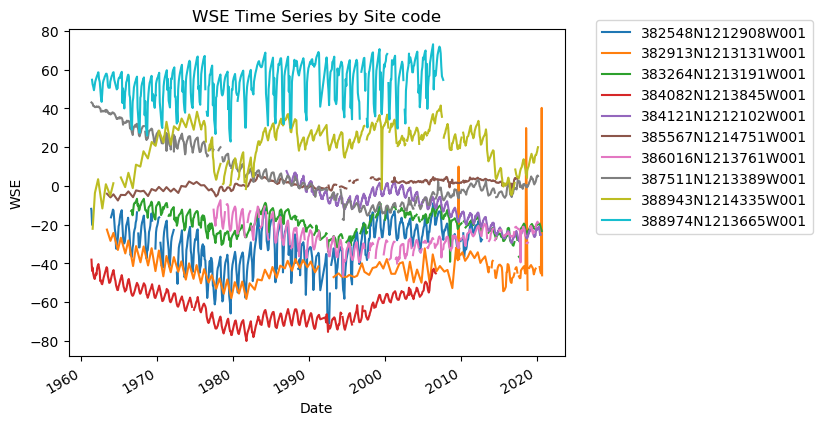

In [9]:
# Sanity check - Plot GWLs for each SITE CODE
import matplotlib.pyplot as plt 

fig, ax = plt.subplots()

for category, group in df_gwl.groupby('SITE_CODE'):
    group.plot(x='Datetime', y='WSE', ax=ax, label=category)

plt.title('WSE Time Series by Site code')
plt.xlabel('Date')
plt.ylabel('WSE')
plt.legend(bbox_to_anchor=(1.05,1.05)) # move the legend outside the plot
plt.show()

I notice a few things here: 
* There are gaps in data
* There are potentially anomalous values in some of the datasets
* It might be nice to standardize the data to compare, i.e. make all observations start at zero. 

How can we go about fixing these? 
* Gaps - interpolation
* Anomalous values - smoothing
* Standardization - difference time series from first value

Let's go about making these modifications.

Anything else you notice about the data? 

### Preprocessing and Filtering

#### Interpolation

We can interpolate missing values using the handy `pandas` function `df.interpolate`, and specify the interpolation method using the `how` argument. 

Let's do this for each site code. In order to accomplish this, we will first create an empty list to store our results, then loop through each unique site code, perform the interpolation, and update the list with the interpolated result. Then, we'll concatenate the results and plot to sanity check. 

In [16]:
interp_results = []

for site in df_gwl['SITE_CODE'].unique():
    site_df = df_gwl[df_gwl['SITE_CODE'] == site].sort_values("Datetime")
    # interp_wse = site_df.loc[:,'WSE'].interpolate(how = 'polynomial',order = 3)
    interp_wse = site_df.loc[:,'WSE'].interpolate(how = 'linear').values
    site_df.loc[:,'WSE_interp'] = interp_wse
    interp_results.append(site_df)

df_gwl_interp = pd.concat(interp_results)

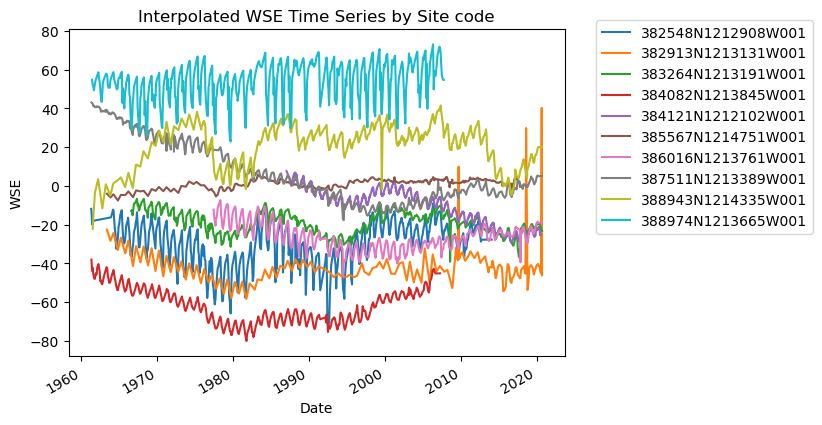

In [17]:
# Sanity check - Plot interpolated GWLs for each SITE CODE

fig, ax = plt.subplots()

for category, group in df_gwl_interp.groupby('SITE_CODE'):
    group.plot(x='Datetime', y='WSE_interp', ax=ax, label=category)

plt.title('Interpolated WSE Time Series by Site code')
plt.xlabel('Date')
plt.ylabel('WSE')
plt.legend(bbox_to_anchor=(1.05,1.05)) # move the legend outside the plot
plt.show()

#### Smoothing 

We can smooth our `WSE` data by taking the rolling average over a given number of rows using the handy `pandas` function `df.rolling`, and specifying the aggregation method using the `.mean()` function. 

Let's do this for each site code. In order to accomplish this, we will first create an empty list to store our results, then loop through each unique site code, perform the interpolation, and update the list with the interpolated result. Then, we'll concatenate our results and plot them to sanity check. 

In [18]:
smooth_results = []

for site in df_gwl_interp['SITE_CODE'].unique():
    site_df = df_gwl_interp[df_gwl_interp['SITE_CODE'] == site].sort_values("Datetime")
    interp_wse_smooth = site_df.loc[:,'WSE_interp'].rolling(5).median() # we smooth over 5 time periods 
    site_df.loc[:,'WSE_interp_smooth'] = interp_wse_smooth
    smooth_results.append(site_df)

df_gwl_smooth = pd.concat(smooth_results)

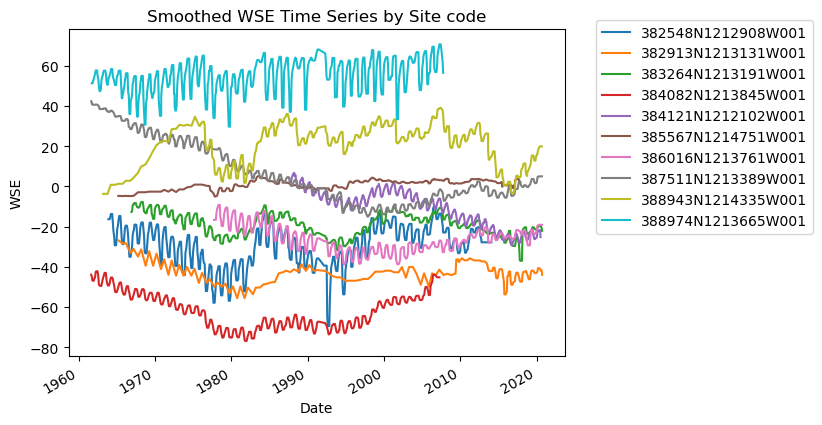

In [19]:
# Sanity check - Plot rolling median GWLs for each SITE CODE

fig, ax = plt.subplots()

for category, group in df_gwl_smooth.groupby('SITE_CODE'):
    group.plot(x='Datetime', y='WSE_interp_smooth', ax=ax, label=category)

plt.title('Smoothed WSE Time Series by Site code')
plt.xlabel('Date')
plt.ylabel('WSE')
plt.legend(bbox_to_anchor=(1.05,1.05)) # move the legend outside the plot
plt.show()

#### Standardize data to begin at zero

We can subtract the first value from the rest of the time series to better facilitate comparison:

In [20]:
df_gwl_smooth.sort_values('Datetime', inplace = True)

standardized_results = []

for site in df_gwl_smooth['SITE_CODE'].unique():
    site_df = df_gwl_smooth[df_gwl_smooth['SITE_CODE'] == site].sort_values("Datetime")
    # wse_standard = site_df.loc[:,'WSE_interp_smooth'].diff().cumsum()
    wse_standard = site_df['WSE_interp_smooth'].dropna() - site_df['WSE_interp_smooth'].dropna().values[0]
    site_df.loc[:,'wse_standard'] = wse_standard
    standardized_results.append(site_df)

df_gwl_standard = pd.concat(standardized_results)

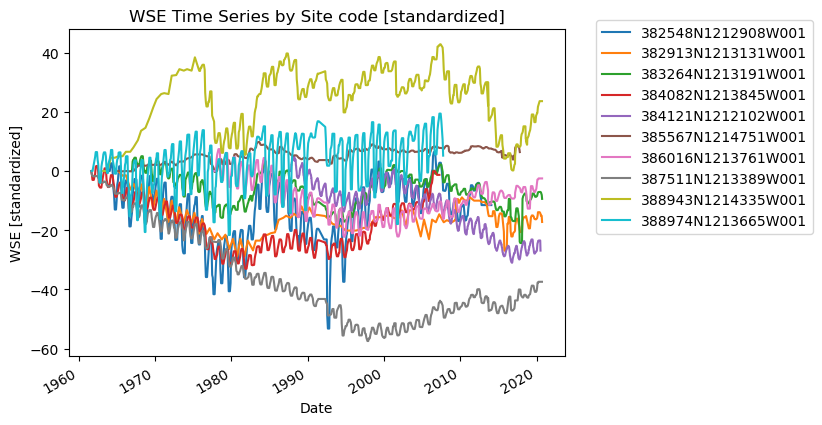

In [21]:
fig, ax = plt.subplots()

for category, group in df_gwl_standard.groupby('SITE_CODE'):
    group.set_index("Datetime")['wse_standard'].plot(ax=ax, label = category)


plt.title('WSE Time Series by Site code [standardized]')
plt.xlabel('Date')
plt.ylabel('WSE [standardized]')
plt.legend(bbox_to_anchor=(1.05,1.05)) # move the legend outside the plot
plt.show()
    

### Data Processing and Synthesis

We have successfully loaded and plotted the groundwater level data. Let's first identify the station data which these groundwater levels correspond to, and then use the geographic information to query an API to retrieve supplementary data. 

#### Joining with station data

In [ ]:
# A simple inner join.
df_joined = pd.merge(df_gwl, df_stns, on="SITE_CODE", how = 'left')

In [ ]:
df_stns = pd.read_csv("./data/gwl/10-sites.csv")
list(df_stns['SITE_CODE'].unique())

In [ ]:
df_gwl

In [ ]:
import os

import requests
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
with open("openet_api.txt","r") as f:
    api_key = f.read()

In [ ]:
def fetch_et_point(point):
    header = {"Authorization": api_key}

    # endpoint arguments
    args = {
      "date_range": [
        "2015-01-01",
        "2023-12-31"
      ],
      "interval": "monthly",
      "geometry": point,
      "interval": "monthly",
      "model": "Ensemble",
      "variable": "ET",
      "reference_et": "gridMET",
      "units": "mm",
      "file_format": "JSON"
    }

    # query the api 
    resp = requests.post(
        headers=header,
        json=args,
        url="https://openet-api.org/raster/timeseries/point"
    )
    
    # build the out dataframe 
    date_times = []
    et = []

    for i in resp.json():
        date_times.append(i['time'])
        et.append(i['et'])
        
    et_df = pd.DataFrame(et)
    et_df.columns = ['et_mm']
    et_df['date'] = date_times
    et_df.set_index('date', inplace = True)
    
    return et_df